# Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

In [3]:
data_files = [
    'inliers_hi_FR_hi_GS_160C.csv',
    'inliers_hi_FR_hi_GS_200C.csv',
    'inliers_hi_FR_lo_GS_160C.csv',
    'inliers_hi_FR_lo_GS_200C.csv',
    'inliers_lo_FR_hi_GS_100C.csv',
    'inliers_lo_FR_hi_GS_160C.csv',
    'inliers_lo_FR_lo_GS_100C.csv',
    'inliers_lo_FR_lo_GS_160C.csv'
]

# Correlation

In [4]:
corr_data = []
file_ids = []

In [5]:
for file in data_files:
    df = pd.read_csv(file)

    X = df.iloc[:, :7]
    y = df.iloc[:, -1]

    corrs = X.apply(lambda col: col.corr(y))
    corr_data.append(corrs)

    file_ids.append(file[8:-4])

In [6]:
corr_df = pd.DataFrame(
    corr_data,
    index=file_ids,
    columns=X.columns
)

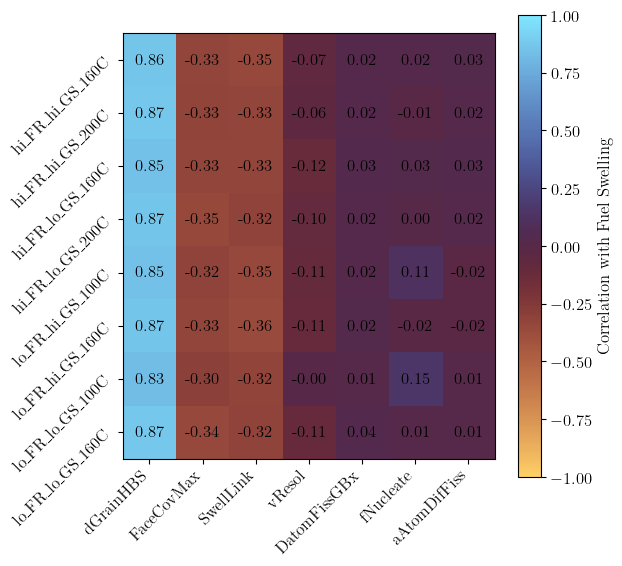

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(corr_df, cmap='managua', vmin=-1, vmax=1)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation with Fuel Swelling')

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))

ax.set_xticklabels(corr_df.columns)
ax.set_yticklabels(corr_df.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), rotation=45, ha='right')

for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        ax.text(
            j, i,
            f'{corr_df.iloc[i, j]:.2f}',
            ha='center', va='center',
        )

plt.show()

# Features

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [9]:
estimator = LinearRegression()

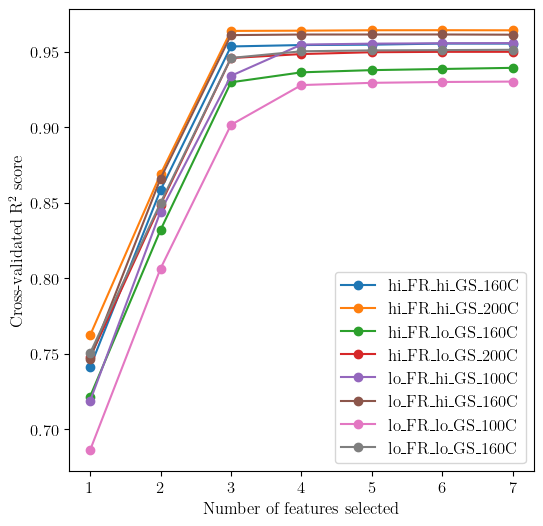

In [10]:
plt.figure(figsize=(6, 6))

for file in data_files:
    df = pd.read_csv(file)

    df.iloc[:, 3] *= 1e17
    df.iloc[:, 6] *= 1e30
    
    X = df.iloc[:, :7]
    y = df.iloc[:, -1]

    xscaler = MinMaxScaler()
    X = xscaler.fit_transform(X)

    scores = []
    for k in range(1, X.shape[1] + 1):
        rfe = RFE(estimator, n_features_to_select=k)
        X_rfe = rfe.fit_transform(X, y)

        score = cross_val_score(estimator, X_rfe, y, cv=5, scoring='r2').mean()
        scores.append(score)

    file_id = file[8:-4]
    plt.plot(range(1, X.shape[1] + 1), scores, marker='o', label=file_id)

plt.xlabel('Number of features selected')
plt.ylabel('Cross-validated R$^2$ score')
plt.legend()
plt.show()